# Кластеризация
__Суммарное количество баллов: 10__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [10]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
from collections import deque
from unionfind import unionfind

In [11]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

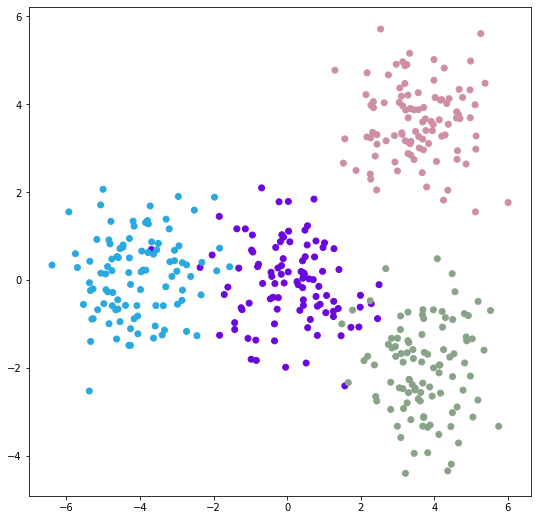

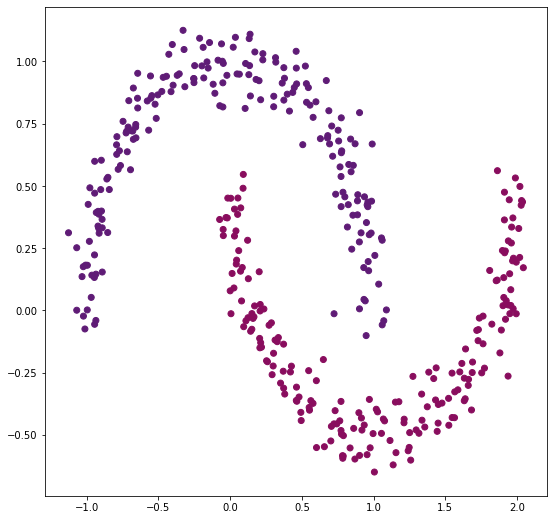

In [12]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (2 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [13]:
def euclidean_distances(x, y):
    r = x - y
    return np.sqrt((r ** 2).sum(axis = 1))

class KMeans:
    def __init__(self, n_clusters, init="random", max_iter=300):
        self.init = init
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        
    def fit(self, X, y=None):
        def random_centroid():
            # sample from the uniform distribution at [0, 1]
            c = np.random.rand(dimensions)
            # make coordinates consistent
            return c * (np.max(X, axis=0) - np.min(X, axis=0)) + np.min(X, axis=0)
        
        n_samples = X.shape[0]
        dimensions = X.shape[1]
        n_clusters = self.n_clusters
        
        # initiating
        if self.init == 'random':
            self.cs = np.array([random_centroid() for _ in range(n_clusters)])
        elif self.init == 'sample':
            inds = np.random.choice(n_samples, n_clusters)
            self.cs = X[inds]
        elif self.init == 'k-means++':
            self.cs = np.array([random_centroid()])
            
            for _ in range(n_clusters - 1):
                nearest_dist = np.zeros(n_samples)
                
                for i in range(n_samples):
                    distances = euclidean_distances(np.repeat(X[i][np.newaxis,:], self.cs.shape[0], axis=0), self.cs)
                    nearest_dist[i] = np.min(distances) ** 2
                    
                ind = np.random.choice(n_samples, 1, p=(nearest_dist / sum(nearest_dist)))
                self.cs = np.concatenate((self.cs, X[ind]))
            
        for _ in range(self.max_iter):
            # update clusters labels for Y
            Y = self.predict(X)
            # update centroids
            for i in range(n_clusters):
                points = np.array([X[j] for j in range(X.shape[0]) if Y[j] == i])
                self.cs[i] = np.mean(points, axis=0) if len(points) > 0 else random_centroid()
        
    def predict(self, X):
        n_samples = X.shape[0]
        Y = np.zeros(n_samples, dtype=np.int8)
            
        for i in range(n_samples):
            distances = euclidean_distances(np.repeat(X[i][np.newaxis,:], self.n_clusters, axis=0), self.cs)
            Y[i] = np.argmin(distances)
            
        return Y

Протестируйте алгоритм на синтетических данных. 
При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

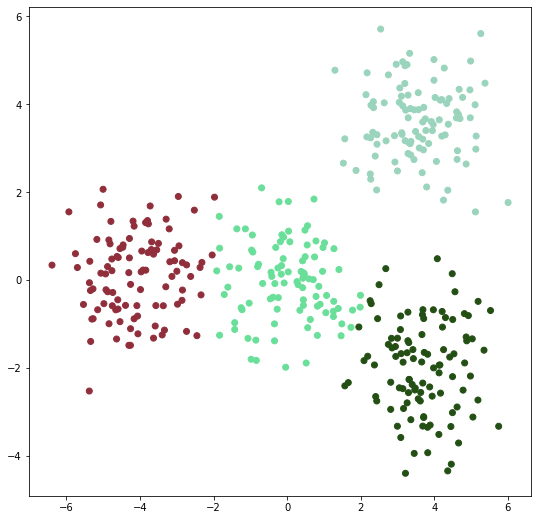

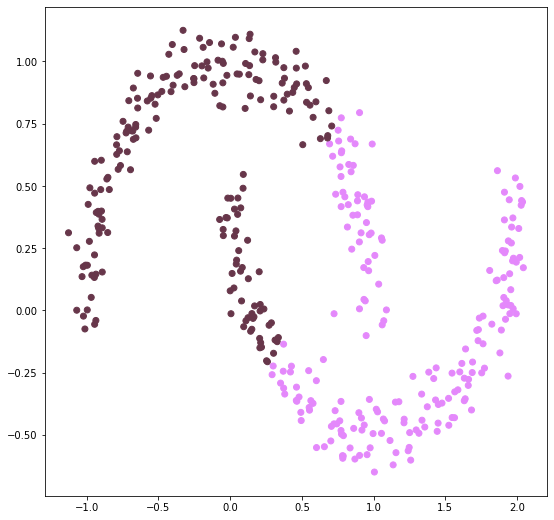

In [14]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (4 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. 
Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [15]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        
    def fit_predict(self, X, y=None):
        def is_core(i):
            return np.sum(distances[i] < self.eps) > self.min_samples
        
        def dfs(i, label):
            visited[i] = True
            labels[i] = label
            
            ds = distances[i]
            n_is = neighbors_inds[i]
            
            for d, n_i in zip(ds[ds < self.eps], n_is):
                labels[n_i] = label
                if is_core(n_i) and not visited[n_i]:
                    dfs(n_i, label)
        
        n_samples = X.shape[0]
        visited = np.zeros(n_samples, dtype=bool)
        labels = np.zeros(n_samples, dtype=np.int8)
        
        tree = KDTree(X, self.leaf_size, self.metric)
        distances, neighbors_inds = tree.query(X, k=n_samples, return_distance=True)
           
        free_label = 0
        for i in range(n_samples):
            if not visited[i] and is_core(i): 
                dfs(i, free_label)
                free_label += 1
        
        return labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

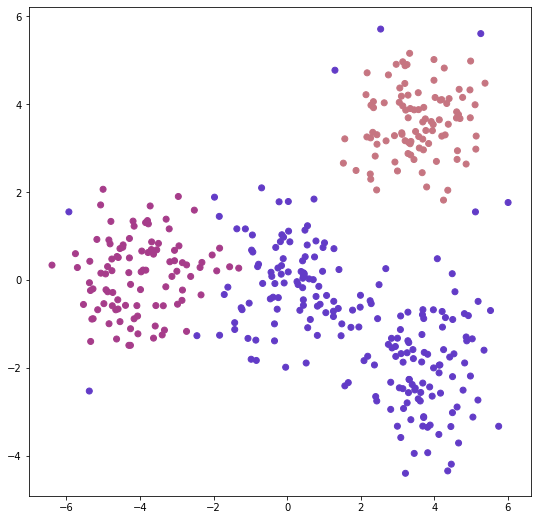

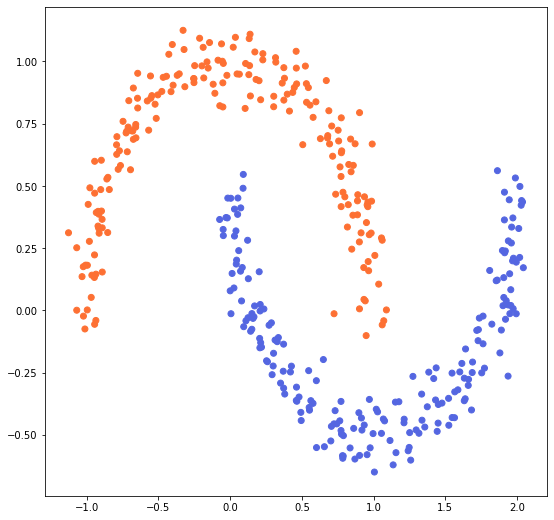

In [16]:
dbscan = DBScan(min_samples=33, eps=1.55, metric='manhattan')
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=0.2)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (4 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. 
Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [17]:
def dist(x, y):
    return np.sqrt((x - y) ** 2)

class AgglomertiveClustering:
    def __init__(self, n_clusters=16, linkage="average"):
        self.n_clusters = n_clusters
        
        if   linkage == 'single':   self.linkage = np.min
        elif linkage == 'complete': self.linkage = np.max
        else:                       self.linkage = np.mean
    
    def fit_predict(self, X, y=None):
        n_samples = X.shape[0]
        u = unionfind(n_samples)
        
        for _ in range(n_samples - self.n_clusters):
            min_cluster_dist = 2e9
            i_min, j_min = 0, 0

            groups = u.groups()
            for i in range(len(groups)):
                for j in range(i + 1, len(groups)):
                    group1, group2 = groups[i], groups[j]
                    ds = [dist(X[i1], X[i2]) for i1 in group1 for i2 in group2]

                    cluster_dist = self.linkage(ds)
                    if cluster_dist < min_cluster_dist:
                        min_cluster_dist = cluster_dist
                        i_min, j_min = i, j

            u.unite(groups[i_min][0], groups[j_min][0])
        
        # calculate labels from unionfind
        labels = np.zeros(n_samples, dtype=np.int8)
        free_label = 0
        for group in u.groups():
            labels[group] = free_label
            free_label += 1
            
        return labels


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

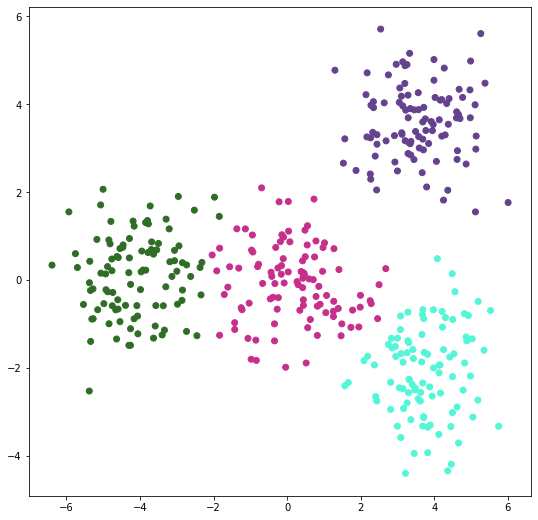

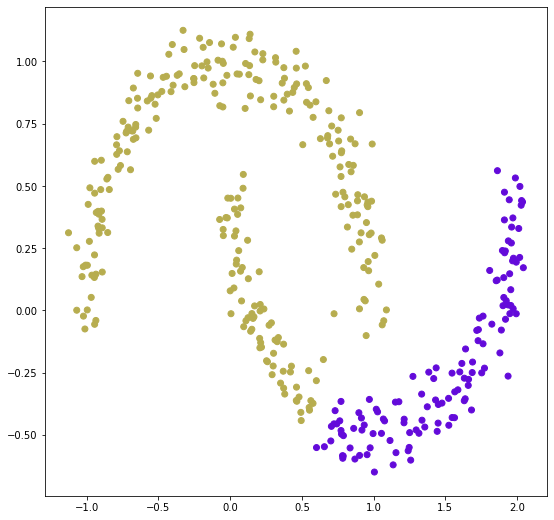

In [21]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2)
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)